<a href="https://colab.research.google.com/github/Jbarrera2000/Portfolio_Diversification_Investops/blob/main/Portfolio_Diversification_Investops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Diversification

In [ ]:
!pip install investops numpy pandas matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 435 kB/s 


## **Market exposure:** 

represents the amount an investor can lose from the risks unique to a particular investment or asset class. It is a tool used to measure and balance risk in an investment portfolio. Having too much exposure to a particular area can indicate a portfolio needs to undergo broader diversification

In [ ]:
import numpy as np
import numba as nb
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import investops as iv
from investops.diversify import (full_exposure, full_exposure_par, 
                                 diversify_weights, log_to_dataframe)
from investops.random import rand_normal, rand_corr_normal, rand_zero
from investops.normalize import normalize_weights
from investops.check import fix_corr_matrix

In [ ]:
# Investops for sparse correlation matrix
from investops.diversify_sparse import (diversify_weights_sparse,
                                        full_exposure_sparse, log_to_dataframe_sparse)
from investops.sparse import (sparse_corr_to_numpy,
                              sparse_to_matrix, matrix_to_sparse)

In [ ]:
iv.__version__

'0.4.0'

In [ ]:
# Random number generator
rng = np.random.default_rng(seed=80085)

## Positive weight and correlations

In [ ]:
# Originally desire porfolio weights
weights_org=np.array([0.1,0.2,0.3])

# Correlation matrix
corr = np.array([[1.0,0.5,0.7],
                [0.5,1.0,0.2],
                [0.7,0.2,1.0]])

In [ ]:
# Calculate and show the full Exposure of the original weights
full_exposure(weights=weights_org, corr=corr)

array([0.17233688, 0.21771541, 0.32726136])

*Interpretation:*
 So the portfolio's Full Exposure is actually 17.2% for Asset 1, 21.8% for Asset 2, and 32.7% for Asset 3, even though the original portfolio weights were only 10%, 20%, and 30%. This is because the Full Exposure measures both the portfolio's direct investment in each asset, as well as the indirect exposure through correlations with other assets in the portfolio.

### THE GOAL:
 find new portfolio weights whose full exposure is equal to the originally desire portfolio weights, and it's done by a function called **diversify_weights**

In [ ]:
# Calculate and show the adjusted portfolio weights 
diversify_weights(weights_org=weights_org, corr=corr)

array([0.0435443 , 0.18911891, 0.28582913])

*Interpretation:*
So we need to invest about 4.3% of the portfolio in Asset 1, 18.9% in Asset 2, and 28.6% in Asset 3, in order for their Full Exposures to equal the originally desired portfolio weights of 10%, 20%, and 30%.

## Name the assets

In [ ]:
# Stock_tickers used as the asset names in the portfolio
names=["AAPL", "GOOG", "MSFT"]

In [ ]:
# Convert correlation matrix from Numpy to Pandas Dataframe
df_corr = pd.DataFrame(dat
                       a=corr, index=names, columns=names)
df_corr

,AAPL,GOOG,MSFT
AAPL,1.0,0.5,0.7
GOOG,0.5,1.0,0.2
MSFT,0.7,0.2,1.0


In [ ]:
# Convert Originally desire porfolio weights array to pandas DataFrame
df_weights_org = pd.DataFrame(data=weights_org, index=names)
df_weights_org

,0
AAPL,0.1
GOOG,0.2
MSFT,0.3


In [ ]:
# Convert original weights from numpy to Pandas Series
ser_weights_org = pd.Series(data=weights_org, index=names)
ser_weights_org

AAPL    0.1
GOOG    0.2
MSFT    0.3
dtype: float64

In [ ]:
# Call the diversifier with the weights being  a pandas series 
diversify_weights(weights_org=ser_weights_org, corr=df_corr)

AAPL    0.043544
GOOG    0.189119
MSFT    0.285829
dtype: float64

In [ ]:
#Call the diversifier with the weights being a pandas Dataframe
diversify_weights(weights_org=df_weights_org, corr=df_corr)

AAPL    0.043544
GOOG    0.189119
MSFT    0.285829
dtype: float64

*NOTE:*

 Use pd series instead of pd dataframe is faster for the diversifier, take it into account for High-Frecuency performance

## Positive / Negative Weights & Correlation

(NEW EXAMPLE)

In [ ]:
weights_org= np.array([0.1,0.2,-0.3])

corr = np.array([[1.0, -0.5, 0.7],
                 [-0.5, 1.0, -0.2],
                 [0.7, -0.2, 1.0]])

In [ ]:
# Calculate the full exposure of the original weights
full_exposure(weights=weights_org, corr=corr)

array([ 0.1       ,  0.2059126 , -0.30397368])

In [ ]:
# Calculate adn show the adjusted portfolio weights
diversify_weights(weights_org=weights_org, corr=corr)

array([ 0.1       ,  0.1941687 , -0.29613922])

*Interpretation:*

So we need to invest 10% of the portfolio in Asset 1 which is the same as the originally desired portfolio weight for Asset 1, because its correlations with the other two assets are deemed "good" so they don't require adjustment. But we should only invest 19.4% in Asset 2 and -29.6% in Asset 3. This makes all the Full Exposures equal to the originally desired portfolio weights of 10%, 20%, and -30%.



## "Crazy" Initial Weights

In [ ]:
#Originally desired portfolio weights
weights_org = np.array([0.1,0.2,-0.3])

weights_guess=np.array([-123,0.001,-789])

corr= np.array([[1.0, -0.5, 0.7],
                 [-0.5, 1.0, -0.2],
                 [0.7, -0.2, 1.0]])

Calculate and show the Full Exposure of the guessed weights.

These are very far from the originally desired portfolio weights.

In [ ]:
full_exposure(weights=weights_guess, corr=corr)

array([-2.50363857e+02,  2.49621714e-01, -8.18580516e+02])

In [ ]:
# Calculate the adjusted portfolio weights, using weights_guess
# as a starting guess for the adjusted weights. Log all iterations.
log=[]
diversify_weights(weights_org=weights_org, corr=corr,
                  weights_guess=weights_guess, log=log)

array([ 0.1       ,  0.1941446 , -0.29615551])

In [ ]:
# Show the log of all the iterations of weight adjustments
log_to_dataframe(weights_org=weights_org, corr=corr, log=log)

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,MSE
Iteration,,,,,,,
0,-123.000000,-250.363857,0.001000,0.249622,-789.000000,-818.580516,2.441050e+05
1,0.049128,0.049128,0.000801,0.003148,-0.289159,-0.289175,1.381862e-02
2,0.100000,0.100000,0.050905,0.056588,-0.299983,-0.301000,6.856036e-03
3,0.100000,0.100000,0.179916,0.185800,-0.298987,-0.302564,6.940797e-05
4,0.100000,0.100000,0.193667,0.199508,-0.296453,-0.300302,1.111106e-07
5,0.100000,0.100000,0.194145,0.199980,-0.296156,-0.300013,1.918659e-10


##Higher Precision

 we want an even higher precision in the adjusted portfolio weights, so their Full Exposures are even closer to the originally desired weights. This is done by setting the argument tol (short for "error tolerance") to a value that is close to, but not equal to zero.

In [ ]:
log=[]
diversify_weights(weights_org=weights_org, corr=corr,
                  tol=1e-20, log=log)

array([ 0.1       ,  0.19416484, -0.29614184])

In [ ]:
log_to_dataframe(weights_org=weights_org, corr=corr, log=log)

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,MSE
Iteration,,,,,,,
0,0.1,0.1,0.200000,0.205913,-0.300000,-0.303974,1.691634e-05
1,0.1,0.1,0.194257,0.200091,-0.296078,-0.299938,4.039732e-09
2,0.1,0.1,0.194169,0.200004,-0.296139,-0.299997,6.963000e-12
3,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,1.200798e-14
4,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,2.070865e-17
5,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,3.571366e-20
6,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,6.159123e-23
7,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,1.061951e-25
8,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,1.841171e-28


Note that the Mean Squared Error (MSE) decreases by several orders of magnitude in each iteration and eventually becomes zero, which means the Full Exposures have become exactly equal to the originally desired portfolio weights

## Time Usage

In [ ]:
#Number of assets in the portfolio
num_assets = 1000

#Originaled desired portfolio weights
#random generated from normal distribution
weights_org= rand_normal(rng=rng, size=num_assets,
                         mean=0.0, std=0.05, low=-0.2, high=0.2)

#Correlation matrix randomly generated from a normal distribution
corr = rand_corr_normal(rng=rng, num_assets=num_assets, mean=0.02)

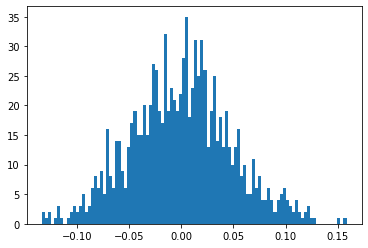

In [ ]:
# Histogram portfolio weights
plt.hist(weights_org, bins=100);

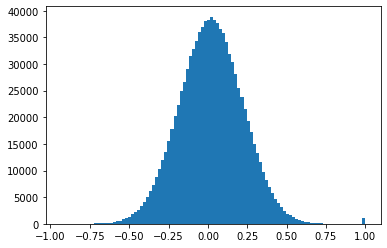

In [ ]:
# Histogram correlation coeficients
plt.hist(corr.flatten(), bins=100);

In [ ]:
%%timeit
#Measure the time usage of the diversification algorithm
diversify_weights(weights_org=weights_org, corr=corr)

30.5 ms ± 4.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


So the diversification algorithm only needed about 20 milli-seconds to converge to a near-optimal solution for a portfolio with 1000 assets. 

The time-complexity is quadratic if you hold the error tolerance fixed (which is the tol argument in the diversify_weights function). This means that for a portfolio of 10,000 assets, you should expect a time-usage of 10*10*20 milli-seconds = 2 seconds.

## Compare Weights Before & After

In [ ]:
weights_new= diversify_weights(weights_org=weights_org, corr=corr)
weights_new[:4]

array([-8.90071313e-04,  3.03100425e-03, -1.41525229e-03,  9.21978430e-05])

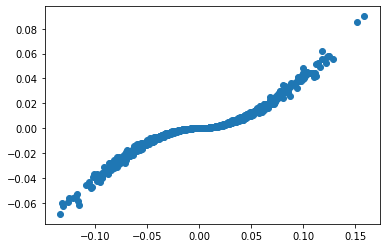

In [ ]:
plt.scatter(weights_org, weights_new)

It appears that the diversification algorithm "compresses" the portfolio weights in a smooth but also non-linear way, so the weights that were originally closer to zero get moved dis-proportionally closer to zero.

## Weight Normalization

The portfolio weights that are output from the function diversify_weights are not normalized, so they can sum to more than 1.

In [ ]:
weights_norm , cash = \
  normalize_weights(weights= weights_new, limit_pos=1.0,
                    limit_neg=-0.5, max_ratio=0.2)

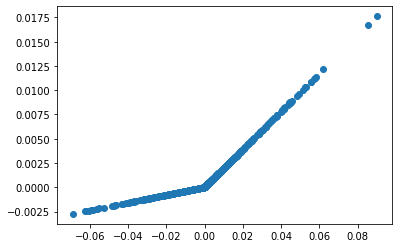

In [ ]:
plt.scatter(weights_new, weights_norm)

## Sparse Correlation Martrix

We will now use a so-called sparse correlation matrix whose elements are mostly zero. 

In [ ]:
# Number of assets in the portfolio
num_assets= 3

In [ ]:
# Originally desired portfolio weights
weights_org = pd.Series(dict(MSFT=0.1, BBBY=0.3, AAPL=0.2))
weights_org

MSFT    0.1
BBBY    0.3
AAPL    0.2
dtype: float64

In [ ]:
# Here the correlation between stocks MSFT and BBBY is 0.5
# And the correlation between BBBY and AAPL is 0.1
corr_sparse= [("MSFT", "BBBY", 0.5), ("AAPL", "BBBY", 0.1)]

In [ ]:
# Converting the sparse correlation matrix into 3 tuples so python can handle it
corr_i, corr_j, corr_coef = zip(*corr_sparse)

#Print the 3 tuples that define the sparse correlation matrix
print(f"corr_i: {corr_i}")
print(f"corr_j: {corr_j}")
print(f"corr_coef: {corr_coef}")

corr_i: ('MSFT', 'AAPL')
corr_j: ('BBBY', 'BBBY')
corr_coef: (0.5, 0.1)


In [ ]:
# Convert the weights and sparse correlation matrix into Numpy arrays 
weights_org_np, corr_i_np, corr_j_np, corr_coef_np = \
  sparse_corr_to_numpy(weights= weights_org, corr_i=corr_i,
                       corr_j=corr_j, corr_coef=corr_coef)
  
print(f"weights_org_np: {weights_org_np}")
print(f"corr_i_np: {corr_i_np}")
print(f"corr_j_np: {corr_j_np}")
print(f"corr_coef_np: {corr_coef_np}")

weights_org_np: [0.1 0.3 0.2]
corr_i_np: [0 2]
corr_j_np: [1 1]
corr_coef_np: [0.5 0.1]


In [ ]:
# Create a dense correlation matrix so we can compare the sparse
# and dense versions of the diversification algorithm later
corr_dense = sparse_to_matrix(sparse_i=corr_i_np, sparse_j=corr_j_np, sparse_v=corr_coef_np,
                              shape=(num_assets, num_assets))

#Make the correlation matrix symetrical
corr_dense += corr_dense.T

#Fill the ddiagonal with 1.
np.fill_diagonal(corr_dense, 1.0)

#Show the dense correlation matrix 
corr_dense


array([[1. , 0.5, 0. ],
       [0.5, 1. , 0.1],
       [0. , 0.1, 1. ]])

In [ ]:
#Calculate the full exposure using SPARSE correlation matrix
full_exposure_sparse(weights=weights_org_np, corr_i=corr_i_np,
                     corr_j=corr_j_np, corr_coef=corr_coef_np)

array([0.13228757, 0.3132092 , 0.20149442])

In [ ]:
#Calculate de full exposure using the DENSE correlation matrix
full_exposure(weights=weights_org_np, corr=corr_dense)

array([0.13228757, 0.3132092 , 0.20149442])

In [ ]:
#Diversify the portfolio weights using SPARSE correlation matrix
diversify_weights_sparse(weights_org=weights_org_np, corr_i=corr_i_np, corr_j=corr_j_np,
                         corr_coef=corr_coef_np)

array([0.07020497, 0.29034873, 0.19855427])

In [ ]:
#Diversify the portfolio weights using DENSE correlation matrix
diversify_weights(weights_org=weights_org_np, corr=corr_dense)

array([0.07020497, 0.29034873, 0.19855427])

In [ ]:
 # Diversify the portfolio weights using the SPARSE correlation matrix. This uses Pandas Series for the weights and lists of strings for corr_i and j
 log_sparse=[]
 diversify_weights_sparse(weights_org=weights_org, corr_i=corr_i,
                          corr_j=corr_j, corr_coef=corr_coef,
                          log=log_sparse)

MSFT    0.070205
BBBY    0.290349
AAPL    0.198554
dtype: float64

In [ ]:
# Diversify the portfolio weights using the DENSE correlation matrix. This uses Pandas Series for the weights and DataFrame for the corr
log_dense=[]
diversify_weights(weights_org=weights_org, corr=corr_dense, log=log_dense)

MSFT    0.070205
BBBY    0.290349
AAPL    0.198554
dtype: float64

In [ ]:
#Show the log for the algorithm using the SPARSE corr.matrix 
df_log_sparse= log_to_dataframe_sparse(log=log_sparse,
                                       weights_org= weights_org_np, corr_i=corr_i_np,
                                       corr_j=corr_j_np, corr_coef=corr_coef_np)
df_log_sparse

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,MSE
Iteration,,,,,,,
0,0.100000,0.132288,0.300000,0.313209,0.200000,0.201494,4.064010e-04
1,0.075593,0.105568,0.287348,0.297606,0.198517,0.199948,1.224562e-05
2,0.071606,0.101551,0.289659,0.299437,0.198568,0.200011,9.078328e-07
3,0.070512,0.100437,0.290203,0.299850,0.198557,0.200003,7.121535e-08
4,0.070205,0.100124,0.290349,0.299958,0.198554,0.200001,5.670957e-09


In [ ]:
# Show the log for the algorithm using DENSE corr matrix
df_log_dense = log_to_dataframe(log=log_dense, weights_org= weights_org, corr=corr_dense)

df_log_dense

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,MSE
Iteration,,,,,,,
0,0.100000,0.132288,0.300000,0.313209,0.200000,0.201494,4.064010e-04
1,0.075593,0.105568,0.287348,0.297606,0.198517,0.199948,1.224562e-05
2,0.071606,0.101551,0.289659,0.299437,0.198568,0.200011,9.078328e-07
3,0.070512,0.100437,0.290203,0.299850,0.198557,0.200003,7.121535e-08
4,0.070205,0.100124,0.290349,0.299958,0.198554,0.200001,5.670957e-09


## BIG EXAMPLE

In [ ]:
# Number of asssets in the portfolio
num_assets = 1000

#generate random portfolio weights 
weights_org = rand_normal(rng=rng, size=num_assets,
                          low=-0.1, high=1.0)

#Generate random correlation matrix 
corr_dense = rand_corr_normal(rng=rng, num_assets=num_assets)

#Randomly set about 99% of the ccorr matriz to zero
corr_dense = rand_zero(rng=rng , x=corr_dense, prob=0.99)

# make the corr matrix symmetrical again
corr_dense += corr_dense.T

#Ensure it is a valid correlation matrix
fix_corr_matrix(corr=corr_dense, copy=False)

#Only use the upper triangle of the corr matrix
corr_dense_triu = np.triu(corr_dense, k=1)

#Convert to a sparse matrix in coordinate (COO) format
corr_i, corr_j, corr_coef = matrix_to_sparse(mat= corr_dense_triu)

In [ ]:
#Convert the sparse matrix to a dense matrix 
mat = sparse_to_matrix(shape=(num_assets, num_assets),
                       sparse_i= corr_i, sparse_j=corr_j, sparse_v=corr_coef)

#Raise an exception if there are big differences
np.testing.assert_allclose(mat, corr_dense_triu)

In [ ]:
#Diversify the portfolio using the SPARSE corr matrix
log_sparse = []
weights_new_sparse= diversify_weights_sparse(weights_org= weights_org,
                                      corr_i=corr_i, corr_j=corr_j, 
                                      corr_coef=corr_coef, log=log_sparse)


In [ ]:
#Diversify the portfolio using the DENSE correlation matrix
log_dense=[]

weights_new_dense = diversify_weights(weights_org=weights_org, corr=corr_dense,
                                      )

In [ ]:
np.testing.assert_allclose(weights_new_sparse, weights_new_dense)

In [ ]:
## Sparse vs Dense Algorithm Results
df_log_sparse = log_to_dataframe_sparse(weights_org=weights_org,
                                         corr_i=corr_i, corr_j=corr_j, corr_coef=corr_coef,
                                         log=log_sparse)
 
df_log_sparse.head()

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,Weight 4,Full Exp. 4,Weight 5,Full Exp. 5,...,Full Exp. 996,Weight 997,Full Exp. 997,Weight 998,Full Exp. 998,Weight 999,Full Exp. 999,Weight 1000,Full Exp. 1000,MSE
Iteration,,,,,,,,,,,,,,,,,,,,,
0,-0.015528,-0.018513,0.006683,0.012504,0.033048,0.038303,0.072795,0.078386,-0.005125,-0.007726,...,0.029659,-0.048243,-0.074906,0.031307,0.038860,-0.014692,-0.016545,-0.000221,-0.002884,4.434873e-05
1,-0.013024,-0.015540,0.003572,0.008100,0.028515,0.033155,0.067603,0.071795,-0.003400,-0.005532,...,0.025225,-0.031071,-0.051338,0.025223,0.031741,-0.013045,-0.014563,-0.000017,-0.000776,8.415078e-07
2,-0.013014,-0.015505,0.002947,0.007234,0.028423,0.033055,0.068544,0.072596,-0.003149,-0.005247,...,0.025119,-0.029198,-0.049332,0.024879,0.031453,-0.013161,-0.014662,-0.000005,-0.000414,1.108019e-07
3,-0.013033,-0.015515,0.002723,0.006908,0.028418,0.033045,0.068732,0.072744,-0.003076,-0.005160,...,0.025098,-0.028554,-0.048684,0.024763,0.031357,-0.013187,-0.014682,-0.000003,-0.000302,1.830199e-08
4,-0.013044,-0.015523,0.002634,0.006778,0.028421,0.033046,0.068780,0.072779,-0.003055,-0.005134,...,0.025094,-0.028295,-0.048430,0.024724,0.031324,-0.013196,-0.014687,-0.000002,-0.000259,3.379296e-09


In [ ]:
df_log_dense = log_to_dataframe(weights_org=weights_org, corr=corr_dense,
                                log=log_dense)

df_log_dense

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,Weight 4,Full Exp. 4,Weight 5,Full Exp. 5,...,Full Exp. 996,Weight 997,Full Exp. 997,Weight 998,Full Exp. 998,Weight 999,Full Exp. 999,Weight 1000,Full Exp. 1000,MSE
Iteration,,,,,,,,,,,,,,,,,,,,,
0,-0.015528,-0.018513,0.006683,0.012504,0.033048,0.038303,0.072795,0.078386,-0.005125,-0.007726,...,0.029659,-0.048243,-0.074906,0.031307,0.038860,-0.014692,-0.016545,-0.000221,-0.002884,4.434873e-05
1,-0.013024,-0.015540,0.003572,0.008100,0.028515,0.033155,0.067603,0.071795,-0.003400,-0.005532,...,0.025225,-0.031071,-0.051338,0.025223,0.031741,-0.013045,-0.014563,-0.000017,-0.000776,8.415078e-07
2,-0.013014,-0.015505,0.002947,0.007234,0.028423,0.033055,0.068544,0.072596,-0.003149,-0.005247,...,0.025119,-0.029198,-0.049332,0.024879,0.031453,-0.013161,-0.014662,-0.000005,-0.000414,1.108019e-07
3,-0.013033,-0.015515,0.002723,0.006908,0.028418,0.033045,0.068732,0.072744,-0.003076,-0.005160,...,0.025098,-0.028554,-0.048684,0.024763,0.031357,-0.013187,-0.014682,-0.000003,-0.000302,1.830199e-08
4,-0.013044,-0.015523,0.002634,0.006778,0.028421,0.033046,0.068780,0.072779,-0.003055,-0.005134,...,0.025094,-0.028295,-0.048430,0.024724,0.031324,-0.013196,-0.014687,-0.000002,-0.000259,3.379296e-09


In [ ]:
# Show the log's min/max difference between SPARSE and DENSE results
df_log_dif= df_log_sparse - df_log_dense
df_log_dif.T.describe().T[["min", "max"]]

,min,max
Iteration,,
0,-1.387779e-17,2.775558e-17
1,-5.551115e-17,2.775558e-17
2,-4.163336e-17,2.775558e-17
3,-4.163336e-17,2.775558e-17
4,-4.163336e-17,4.163336e-17


## Parallel vs. Serial Execution

The function full_exposure_par is the parallel version of the function full_exposure, and the function diversify_weights can be run in parallel mode by passing the argument parallel=True.